This is the code for the final project in the Advaced Imaging Augmentation Course. 

This code includes the 16 layer architecture, 11 layer architecture, code to run all - blue images and code to use the smaller dataset. 

The default is set to run the 16 layer model. If otherwise is desired, follow the instructions in the comments to change accordingly. 

In [1]:
!pip install livelossplot --quiet

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn import decomposition, manifold, svm
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tqdm
import copy
import random
import time
from livelossplot import PlotLosses
import pandas as pd

In [3]:
SEED = 123
random.seed(SEED)
np.random.seed(SEED)

In [4]:
# connect to google colab - images are stored there in a zip file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# set device to cude to use gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data Preparation
The data was taken from: [Link to image data](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=33948919#33948919d170e52bc57d4c67b747b57bf88c460f)

The images are divided into folders, each named by the cancer type for a total of 13 folders. We will extract the image path and from it get the label for each image - by the folder name. 

In [6]:
!mkdir "/content/TIL_images"

In [7]:
!cp "/content/drive/MyDrive/TIL_maps_after_thres_v1.zip" "/content/TIL_images"

In [ ]:
output = !unzip "/content/TIL_images/TIL_maps_after_thres_v1.zip" -d "/content/TIL_images"
output[-2:]

-- Before moving on, if the desire is to run the model with the smaller set of classes, they need to be erased form the folder.

-- In the smaller set, the 6 classes that were used were : "blca", "coad", "luad", "lusc", "skcm", "ucec"

In [ ]:
# extract image paths into list
import os
root_path = '/content/TIL_images/TIL_maps_after_thres_v1'

i = 0
image_list = list()
for subdir, dirs, files in os.walk(root_path):
  for file in files:
      image_list.append(os.path.join(subdir, file))
image_list[1]

In [10]:
len(image_list)

5203

In [11]:
# create variable with labels of all classes
classes_orig = ["blca", "brca", "cesc", "coad",
          "luad", "lusc", "paad", "prad","read", "skcm", "stad", "ucec", "uvm"]

# smaller set of classes
classes_small = ["blca", "coad", "luad", "lusc", "skcm", "ucec"]

# set classes variable. If the smaller set is used, set classes to classes_small
classes = classes_orig

image_dic = {}
for key in classes:
  image_dic[key] = 0

In [12]:
# take image_list and classify each image with label
images = list()
labels = list()

for i, image in enumerate(image_list):
  if i==0:
    continue
  path_of_image = os.path.dirname(image)
  label_of_image = os.path.basename(path_of_image)
  image_dic[str(label_of_image)] += 1
  images.append(image)
  labels.append(label_of_image)

In [ ]:
# check an image for code testing
import matplotlib.pyplot as plt
from PIL import Image

idx=0
image = Image.open(images[idx])
plt.imshow(transforms.ToPILImage()(transforms.ToTensor()(image)), interpolation="bicubic")
print(image.getpixel)
print(labels[idx])

Now that we completed the loading of the data, let's take a look at the distribution of it.

In [ ]:
# count and show distribution of data
label_list = list(image_dic.keys())
amount_list = list(image_dic.values())
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(label_list,amount_list)
plt.show()

We see that the data is not evenly distributed and we need to make a note of that. In addition, we will have to do some image augmentation because we don't have a large amount of data for each type.

## Data Processing
The images are of different sizes so we need to make them all the same size. 
We will do this first as we need to evaluate the mean and standard deviation of the images for normalization.

In [15]:
IMAGE_RESIZE = 100

tensors_list = []
for idx, i in enumerate(images):
  image = Image.open(i)
  tensor_image = transforms.ToTensor()(image)
  tensor_image = transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE), interpolation=torchvision.transforms.InterpolationMode.NEAREST)(tensor_image)
  tensors_list.append(tensor_image)

tensors = torch.stack(tensors_list, axis = 0)
# calculate mean and standard deviation
mean = tensors.mean().item()
std = tensors.std().item()

print("Mean is: " + str(mean))
print("Standard Deviation is: " + str(std))

Below we have the code to turn the images to be all blue.

In [ ]:
# code to turn the images to all - blue (to not show TILs)
def red_to_blue(x):
  red  = torch.Tensor([1.0, 0, 0]).unsqueeze(-1).unsqueeze(-1)
  blue = torch.Tensor([0, 0, 1.0]).unsqueeze(-1).unsqueeze(-1)
  image_with_red_to_blue = torch.where((x[0]==1).unsqueeze(0), blue, x)
  return image_with_red_to_blue

Below we will set the different transformer variables - each one will be used accoring to what we want to check.

In [17]:
# train transform to use if we want to test all - blue images
train_transforms_BLUE = transforms.Compose([
                           transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE), interpolation=torchvision.transforms.InterpolationMode.NEAREST),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.RandomRotation(degrees=(-90, 90)),
                           transforms.RandomVerticalFlip(p=0.5),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: red_to_blue(x)),
                           transforms.Normalize(mean = mean, 
                                                std = std)])
# regular train transform
train_transforms = transforms.Compose([
                           transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE), interpolation=torchvision.transforms.InterpolationMode.NEAREST),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.RandomRotation(degrees=(-90, 90)),
                           transforms.RandomVerticalFlip(p=0.5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean, 
                                                std = std)])
# regular test transform
test_transforms = transforms.Compose([
                           transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE), interpolation=torchvision.transforms.InterpolationMode.NEAREST),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean, 
                                                std = std)])

Now we will create the the TILDataset class which inherits from Dataset which will allow us to crease Dataset variables to give the Dataloaders.

In [19]:
class TILDataset(Dataset):
    def __init__(self, image_set, label_set, transform):
        self.image_set = image_set
        self.transform = transform
        self.labels = label_set
        self.n_samples = len(self.image_set)
        self.classes = {"blca":0, "brca":1, "cesc":2, "coad":3,
                        "luad":4, "lusc":5, "paad":6, "prad":7,
                        "read":8, "skcm":9, "stad":10, "ucec":11, "uvm":12}
        self.class_LB_to_str = {0:"blca", 1:"brca", 2:"cesc", 3:"coad",
                        4:"luad", 5:"lusc", 6:"paad", 7:"prad",
                        8:"read", 9:"skcm", 10:"stad",11:"ucec",12:"uvm"}
        
    # support indexing such that dataset[i] can be used to get i-th sample
    # gets index, takes from image_set (List[String]) one string, and returns an image and a label
    def __getitem__(self, index):
        img_path = self.image_set[index]
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        label_string = self.labels[index]

        return img, self.classes[label_string]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples
    

Now that we created our transformers and the Dataset class, we will divide the data into train and validation.

The data will be divided into 90% training and 10% validation. We want to model to learn as much information as possible but also have enough samples to see how well it did in predicting the validation set. 

In [ ]:
TRAIN_RATIO = 0.9

# the data will be divided into 90% training 10% validation
idx_train_img = int(len(images) * TRAIN_RATIO)

images_np = np.array(images)
labels = np.array(labels)
indices = np.arange(images_np.shape[0])

# shuffle data so they are not in order
np.random.shuffle(indices)

# separate the images and the labels
images_shuffle = images_np[indices]
labels_shuffle = labels[indices]

# split to train and validation
train_images = images_shuffle[:idx_train_img]
train_labels = labels_shuffle[:idx_train_img]
validation_images = images_shuffle[idx_train_img + 1:]
validation_labels = labels_shuffle[idx_train_img + 1:]

# create dataset and split to training and validation
train_data = TILDataset(train_images, train_labels, train_transforms)
validation_data = TILDataset(validation_images, validation_labels, test_transforms)

# create all- blue dataset
train_data_BLUE = TILDataset(train_images, train_labels, train_transforms_BLUE)

# check one image from the training set for code testing
print("Image from training set")
import matplotlib.pyplot as plt
from PIL import Image
img_idx = 2
image = Image.open(train_images[img_idx])
plt.imshow(transforms.ToPILImage()(transforms.ToTensor()(image)), interpolation="bicubic")
print(image.getpixel)
print(train_labels[img_idx])

In [ ]:
# check one image from the testing set for code testing
print("Image from validation set")
import matplotlib.pyplot as plt
from PIL import Image

image_1 = Image.open(validation_images[100]) 
plt.imshow(transforms.ToPILImage()(transforms.ToTensor()(image_1)), interpolation="bicubic")
print(image_1.getpixel)
print(validation_labels[100])

We made sure the splitting of the data went well.

Now we will use our TILDataset class to create the training and validation DataLoaders.

In [50]:
# set the train data to use
# to use all - blue images set variable to - train_data_BLUE
train_data_to_use = train_data

In [51]:
# set batch size and num_workers
BATCH_SIZE = 64
NUM_WORKERS = 4

# create iterators using DataLoader
train_iterator = DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS)
valid_iterator = DataLoader(validation_data, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS)

# create all - blue iterator
train_iterator_BLUE = DataLoader(train_data_BLUE, shuffle=True, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS)

In [52]:
# set the train iterator to use
# to use all - blue iterator set variable to - train_iterator_BLUE
train_iterator_to_use = train_iterator

We'll plot out a few images to ensure the transformations look sensible - making sure to re-normalize our data so we can view it with the correct colors.

In [53]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (10, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]
        if normalize:
            image = normalize_image(image)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [ ]:
N_IMAGES = 25
images_to_show, labels_to_show = zip(*[(image, label) for image, label in 
                           [train_data_to_use[i] for i in range(N_IMAGES)]])
classes = validation_data.class_LB_to_str
plot_images(images_to_show, labels_to_show, classes)
images_to_show[0].shape

## SVM Model

Before we dive deep into a CNN based model, lets use a simpler machine learing model to see how well it classifies out data. In this case we will use a Support Vector Machine : SVM.

### Generating the Model

In [ ]:
# take image_list and classify each image with label.
images_new = list()
labels_new = list()

for i, image in enumerate(image_list):
  if i==0:
    continue
  path_of_image = os.path.dirname(image)
  label_of_image = os.path.basename(path_of_image)
  image_dic[str(label_of_image)] += 1
  images_new.append(image)
  labels_new.append(label_of_image)

In [ ]:
# create data for pca
all_data_for_pca = TILDataset(images_new, labels_new, train_transforms)
all_data_iterator = DataLoader(all_data_for_pca, shuffle=True, batch_size = 1)

In [ ]:
images_pca = []
labels_pca = []
for image, label in all_data_iterator:
  image_to_add = image[0].numpy().flatten()
  label_to_add = label[0]
  images_pca.append(image_to_add)
  labels_pca.append(label_to_add)

In [ ]:
labels_pca_items = []
for label in labels_pca:
  labels_pca_items.append(label.item())

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(images_pca)
converted_data.shape

(5202, 2)

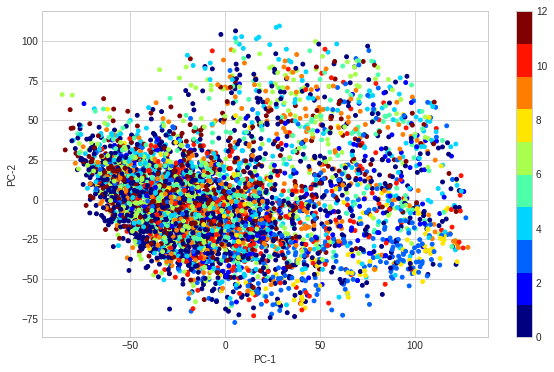

In [ ]:
# code to create PCA
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map , c = labels_pca_items)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

From the PCA plot above we can see that the many of the features got lost and there wasn't any clustering. This will probably affect how well our SVM model does, but also enhances the need to use a deep network that will capture all the features.

In [ ]:
pd_data = pd.DataFrame(converted_data)
pd_label = pd.Series(labels_pca_items)
X_train, X_test, Y_train, Y_test = train_test_split(pd_data, pd_label, test_size=.2, random_state=1234123)

In [ ]:
# create SVM classifier 
# One vs. One
svm_classifier_one = OneVsOneClassifier(svm.SVC(kernel='linear'))
# One vs. Rest
svm_classifier_rest = OneVsRestClassifier(svm.SVC(kernel='linear'))

# set which classifier to use 
svm_classifier = svm_classifier_rest

# train model
svm_classifier.fit(X_train, Y_train)

# predict
pred_labels = svm_classifier.predict(X_test)

### Evaluating the Model

Now that we've trained our SVM model model let's evaluate its metrics.

In [ ]:
# calculate accuracy
accuracy = metrics.accuracy_score(Y_test, pred_labels)
accuracy = round(accuracy, 2)
print(f"SVM model accuracy : {accuracy*100}%")

## CNN Model

Now we will create our model based in the VGG architecture.

In [55]:
# function to create the layers according to given configuration
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3
    for conf in config:
        if conf == 'MaxPool':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, conf, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(conf), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = conf
    return nn.Sequential(*layers)

In [56]:
class TIL_VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features
        # we will use the AdaptiveAvgPool to allow different sized images to be given to the code
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

We will create both the 11 layer and the 16 layer configurations.
Both are based on the VGG architechture, each having a different number of layers.

In [57]:
# 11 layer model
vgg11_config = [64, 'MaxPool', 128, 'MaxPool', 256, 256, 'MaxPool', 512, 512, 'MaxPool', 512, 512, 'MaxPool']

# 16 layer model
vgg16_config = [64, 64, 'MaxPool', 128, 128, 'MaxPool', 256, 256, 256, 'MaxPool', 512, 512, 512, 'MaxPool', 512, 512, 
                512, 'MaxPool']

In [ ]:
# set configuration according to desired model 
# to run the 11 layer model - set variable to vgg11_config
config_to_use = vgg16_config

In [ ]:
# set OUTPUT_DIM to 6 is the smaller dataset was used
OUTPUT_DIM = 13
vgg_layers = get_vgg_layers(config_to_use, batch_norm = True)
model = TIL_VGG(vgg_layers, OUTPUT_DIM)

# look at the model
print(model)

### Training the model

In [60]:
# set model to use
model_to_use = model

In [61]:
START_LR = 1e-7
# set optimizer (Adam) and criterion (Cross Entropy Loss)
optimizer = optim.Adam(model_to_use.parameters(), lr = START_LR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model_to_use = model_to_use.to(device)
criterion = criterion.to(device)

Below we will use a learning rate finder to find the optimal learning rate for our model.

In [144]:
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)
        return inputs, labels
        
    def get_batch(self):
        return next(self)

In [145]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        lrs = []
        losses = []
        best_loss = float('inf')
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        iterator = IteratorWrapper(iterator)  
        for iteration in tqdm.tqdm(range(num_iter)):
            loss = self._train_batch(iterator)
            lrs.append(lr_scheduler.get_last_lr()[0])
            # update lr
            lr_scheduler.step()
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]               
            if loss < best_loss:
                best_loss = loss
            losses.append(loss)           
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break                       
        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))      
        return lrs, losses

    def _train_batch(self, iterator):
        self.model.train()
        self.optimizer.zero_grad()        
        x, y = iterator.get_batch()       
        x = x.to(self.device)
        y = y.to(self.device)
        y_pred = self.model(x)
        if isinstance(y_pred, tuple):
          y_pred = y_pred[0]       
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [146]:
END_LR = 10
NUM_ITER = 100

# call LRFinder with set parameters
lr_finder = LRFinder(model_to_use, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator_to_use, END_LR, NUM_ITER)

 73%|███████▎  | 73/100 [00:07<00:02, 10.15it/s]


Stopping early, the loss has diverged


In [147]:
# function to plot the learning rate finder
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

In [ ]:
plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 20)

We can see that the best learning rate is around $1x10^{-5}$, because it's in the middle of the decline. 

In [62]:
# set found learning rate and update optimizer
FOUND_LR = 1e-5
optimizer = optim.Adam(model.parameters(), lr = FOUND_LR)

In [63]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [64]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for image, label in iterator:       
        image = image.to(device)
        label = label.to(device)        
        optimizer.zero_grad()   
        y_pred = model(image)
        if isinstance(y_pred, tuple):
          y_pred = y_pred[0] 
        loss = criterion(y_pred, label)     
        acc = calculate_accuracy(y_pred, label)      
        loss.backward()      
        optimizer.step()       
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [65]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for image, label in iterator:
            image = image.to(device)
            label = label.to(device)
            y_pred = model(image)
            if isinstance(y_pred, tuple):
              y_pred = y_pred[0] 
            loss = criterion(y_pred, label)
            acc = calculate_accuracy(y_pred, label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [66]:
# helper function to tell us how long each epoch takes
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Run Model

In [ ]:
liveloss = PlotLosses()
logs = {}
# set number of epochs
# if the model is the 11 layer model, set to 75 to prevent overfitting
EPOCHS = 100

best_valid_loss = float('inf')
for epoch in tqdm.tqdm(range(EPOCHS)):
    start_time = time.monotonic()

    train_loss, train_acc = train(model_to_use, train_iterator_to_use, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model_to_use, valid_iterator, criterion, device)

    logs['train accuracy'] = train_acc
    logs['train loss'] = train_loss

    logs['validation accuracy'] = valid_acc   
    logs['validation loss'] = valid_loss
    

    liveloss.update(logs)
    liveloss.send()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_to_use.state_dict(), 'tut4-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Plot PCA Results

In [68]:
def get_representations(model, iterator):
    model.eval()
    outputs = []
    intermediates = []
    labels = []
    with torch.no_grad(): 
        for (image, label) in iterator:
            image = image.to(device)
            y_pred, _ = model(image)
            outputs.append(y_pred.cpu())
            labels.append(y)       
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)
    return outputs, labels

In [69]:
outputs, labels = get_representations(model, train_iterator_to_use)

In [70]:
# calculate PCA
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [71]:
def plot_representations(data, labels, classes, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

Plot ROC Curve

In [73]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for image, label in iterator:
            image = image.to(device)
            y_pred, _ = model(image)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(image.cpu())
            labels.append(label.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

In [76]:
images, labels, probs = get_predictions(model_to_use, valid_iterator)
# predicted label for each image
pred_labels = torch.argmax(probs, 1)
labels.detach().numpy()

In [ ]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(classes):
        false_postive_rate, true_positive_rate, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(false_postive_rate, true_positive_rate, label = '%s (AUC:%0.2f)'  % (c_label, auc(false_postive_rate, true_positive_rate)))
    c_ax.plot(false_postive_rate, false_postive_rate, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(labels.detach().numpy(), pred_labels.detach().numpy()))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show() 

Plot Confusion Matrix

In [78]:
# create confusion matrix
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)